In [203]:
import numpy as np
import matplotlib.pyplot as plt

In [230]:
class NeuralNetwork(object):
    
    #############################################################################################
    #INPUTS: learning_rate - how big step to perform in convex optimization
    #        epochs - how many times trainging of neural network will be performed
    #        reg - regularization constant
    #        init - way that weights will be initialized (default value is random)
    #        update - technique that will be used to update weights and biases
    #        momentum - this parameter is used just in momentum type of update - (velocity = 0)
    #        activation - which activation function will be used on HIDDEN layers
    #        dropout - (normal value = 0.5) if it's 0, dropout won't be performed
    #        random_init - setting seed for random 
    #############################################################################################
    def __init__(self, learning_rate=0.01, reg=0.1, epochs=10001, init='he_et', activation='relu', update='SGD', verbose=False, momentum=0.9, dropout=0, random_init=None):
        self.learning_rate = learning_rate
        self.reg = reg
        self.epochs = epochs
        self.init = init
        self.verbose = verbose
        self.update = update
        self.momentum = momentum
        self.activation = activation
        self.dropout = dropout
#         np.random.seed(random_init)
        
    #ACTIVATION FUNCTIONS - FORWARD_PROP###############################################
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)
   
    ####################################################################################
    
    #ACTIVATION FUNCTIONS - BACK_PROP###################################################
    def sigmoid_der(self, x):
        return (1 - x) * x
    
    def relu_der(self, x):
        return 1. * (x > 0)
    
    def tanh_der(self, x):
        return 1.0 - np.tanh(x)**2
   
    def leaky_relu_der(self, x, alpha=0.01):
        gradients = 1. * (x > 0)
        gradients[gradients == 0] = alpha
        return gradients  
    #####################################################################################
    
    #LOSS FUNCTION#######################################################################
    #INPUT: x - outputs from neural network
    #       no_of_samples - numbers of samples in training set
    #       y - training labels
    #
    #OUTPUT: loss/error for current epoche
    def softmax_loss(self, x, no_of_samples, y):
        logs = -np.log(x[range(no_of_samples), y])
        data_loss = np.sum(logs)/no_of_samples
        reg_loss = 0.5*self.reg * np.sum(self.W1*self.W1) + 0.5*self.reg*np.sum(self.W2*self.W2)
        loss = data_loss + reg_loss
        return loss
    ######################################################################################
    
    #TRAIN NEURAL NETWORK#################################################################
    #INPUT: X - training features
    #       y - training labels
    #
    #OUTPUT: loss_history - list of losses per epoche
    def train(self, X, y):
        
        #ADITIONAL VARIABLES##################
        self.y_train = y.reshape(y.shape[0],1)
        loss_history = []
        #for momentum update
        vW1 = 0
        vb1 = 0
        vW2 = 0
        vb2 = 0
        vW3 = 0
        vb3 = 0
        ######################################
        
        #WEIGHTS INIT#######################################################
        if self.init == 'random':
            self.W1 = np.random.randn(X.shape[1], 6)
            self.b1 = np.zeros(6) / np.sqrt(6)
            self.W2 = np.random.randn(6, 6)
            self.b2 = np.zeros(6)
            self.W3 = np.random.randn(6, 1)
            self.b3 = np.zeros(1)
       
        elif self.init == 'xavier':
            self.W1 = np.random.randn(X.shape[1], 6) / np.sqrt(X.shape[1])
            self.b1 = np.zeros(6) / np.sqrt(6)
            self.W2 = np.random.randn(6, 6) / np.sqrt(X.shape[1])
            self.b2 = np.zeros(6) / np.sqrt(6)
            self.W3 = np.random.randn(6, 1) / np.sqrt(6)
            self.b3 = np.zeros(1) / np.sqrt(1)
        
        elif self.init == 'he_et':
            self.W1 = np.random.randn(X.shape[1], 6) / np.sqrt(2.0/X.shape[1])
            self.b1 = np.zeros(6) / np.sqrt(2.0/6)
            self.W2 = np.random.randn(6, 6) / np.sqrt(2.0/X.shape[1])
            self.b2 = np.zeros(6) / np.sqrt(2.0/6)
            self.W3 = np.random.randn(6, 1) / np.sqrt(2.0/6)
            self.b3 = np.zeros(1) / np.sqrt(2.0/1)
        ######################################################################
       
        #Training loop
        for i in range(self.epochs):
            l1, l2, scores = self.forward_prop(X)
            
            #ERROR FOR BINARY CLASS
            scores_error = self.y_train - scores
            loss_history.append(np.mean(np.abs(scores_error)))
            
            #NOTE FOR ERROR: for more classes user softmax_loss to calculate loss
            
            #VIZUALIZATION PART: 
            if self.verbose == True:
                if i % 1000 == 0:
                    print("Epoche: ", i , "Loss: ", np.mean(np.abs(scores_error)))
             
            #BACKPROP######################################
            if self.activation == 'relu':
                scores_delta = scores_error*self.sigmoid_der(scores)
                l2_error = scores_delta.dot(self.W3.T)
                l2_delta = l2_error*self.relu_der(l2)
                l1_error = l2_delta.dot(self.W2.T)
                l1_delta = l1_error*self.relu_der(l1)
            
            elif self.activation == 'sigmoid':
                scores_delta = scores_error*self.sigmoid_der(scores)
                l2_error = scores_delta.dot(self.W3.T)
                l2_delta = l2_error*self.sigmoid_der(l2)
                l1_error = l2_delta.dot(self.W2.T)
                l1_delta = l1_error*self.sigmoid_der(l1)
                
            elif self.activation == 'tanh':
                scores_delta = scores_error * self.sigmoid_der(scores)
                l2_error = scores_delta.dot(self.W3.T)
                l2_delta = l2_error * self.tanh_der(l2)
                l1_error = l2_delta.dot(self.W2.T)
                l1_delta = l1_error * self.tanh_der(l1)
                
            elif self.activation == 'leaky_relu':
                scores_delta = scores_error * self.sigmoid_der(scores)
                l2_error = scores_delta.dot(self.W3.T)
                l2_delta = l2_error * self.leaky_relu_der(l2)
                l1_error = l2_delta.dot(self.W2.T)
                l1_delta = l1_error * self.leaky_relu_der(l1)
            ##############################################
            
            #REGULARIZATION#######################
            scores_delta = self.reg * scores_delta
            l2_delta = self.reg * l2_delta
            l1_delta = self.reg * l1_delta
            ######################################
            
            if self.update == 'SGD':
                self.W1 += X.T.dot(l1_delta) * self.learning_rate
                self.b1 += np.sum(np.sum(l1_delta, axis=0, keepdims=True) * self.learning_rate, axis=1)
                self.W2 += l1.T.dot(l2_delta) * self.learning_rate
                self.b2 += np.sum(np.sum(l2_delta, axis=0, keepdims=True) * self.learning_rate, axis=1)
                self.W3 += l2.T.dot(scores_delta) * self.learning_rate
                self.b3 += np.sum(np.sum(scores_delta, axis=0, keepdims=True) * self.learning_rate, axis=1)
            
            elif self.update == 'momentum':
                vW1 = self.momentum * vW1 *  X.T.dot(l1_delta) * self.learning_rate
                self.W1 += vW1
                vb1 = self.momentum * vb1 * np.sum(np.sum(l1_delta, axis=0, keepdims=True) * self.learning_rate, axis=1)
                self.b1 += vb1
                vW2 = self.momentum * vW2 *  l1.T.dot(l2_delta) * self.learning_rate
                self.W2 += vW2
                vb2 = self.momentum * vb2 * np.sum(np.sum(l2_delta, axis=0, keepdims=True) * self.learning_rate, axis=1)
                self.b2 += vb2
                vW3 = self.momentum * vW3 *  l2.T.dot(scores_delta) * self.learning_rate
                self.W3 += vW3
                vb3 = self.momentum * vb3 * np.sum(np.sum(scores_delta, axis=0, keepdims=True) * self.learning_rate, axis=1)
                self.b3 += vb3
                
        return loss_history
    ######################################################################################
    
    #FORWARD PASS#########################################################################
    #INPUT: X -  data to be processed through neural net
    # 
    #OUTPUT: results per layer and SCORES as a final output from the network
    #NOTE: This function needs to be canged depends on just number of layer
    def forward_prop(self, X):
        if self.dropout == 0:
            if self.activation == 'relu':
                l1 = self.relu(np.dot(X, self.W1) + self.b1)
                l2 = self.relu(np.dot(l1, self.W2) + self.b2)
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)

            elif self.activation == 'sigmoid':
                l1 = self.sigmoid(np.dot(X, self.W1) + self.b1)
                l2 = self.sigmoid(np.dot(l1, self.W2) + self.b2)
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)

            elif self.activation == 'tanh':
                l1 = self.tanh(np.dot(X, self.W1) + self.b1)
                l2 = self.tanh(np.dot(l1, self.W2) + self.b2)
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)

            elif self.activation == 'leaky_relu':
                l1 = self.leaky_relu(np.dot(X, self.W1) + self.b1)
                l2 = self.leaky_relu(np.dot(l1, self.W2) + self.b2)
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)
        else:
            if self.activation == 'relu':
                l1 = self.relu(np.dot(X, self.W1) + self.b1)
                mask1 = np.random.randn(l1.shape[0], l1.shape[1]) < self.dropout
                l1 *= mask1
                l2 = self.relu(np.dot(l1, self.W2) + self.b2)
                mask2 = np.random.randn(l2.shape[0], l2.shape[1]) < self.dropout
                l2 *= mask2
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)

            elif self.activation == 'sigmoid':
                l1 = self.sigmoid(np.dot(X, self.W1) + self.b1)
                mask1 = np.random.randn(l1.shape[0], l1.shape[1]) < self.dropout
                l1 *= mask1
                l2 = self.sigmoid(np.dot(l1, self.W2) + self.b2)
                mask2 = np.random.randn(l2.shape[0], l2.shape[1]) < self.dropout
                l2 *= mask2
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)

            elif self.activation == 'tanh':
                l1 = self.tanh(np.dot(X, self.W1) + self.b1)
                mask1 = np.random.randn(l1.shape[0], l1.shape[1]) < self.dropout
                l1 *= mask1
                l2 = self.tanh(np.dot(l1, self.W2) + self.b2)
                mask2 = np.random.randn(l2.shape[0], l2.shape[1]) < self.dropout
                l2 *= mask2
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)

            elif self.activation == 'leaky_relu':
                l1 = self.leaky_relu(np.dot(X, self.W1) + self.b1)
                mask1 = np.random.randn(l1.shape[0], l1.shape[1]) < self.dropout
                l1 *= mask1
                l2 = self.leaky_relu(np.dot(l1, self.W2) + self.b2)
                mask2 = np.random.randn(l2.shape[0], l2.shape[1]) < self.dropout
                l2 *= mask2
                yHat = self.sigmoid(np.dot(l2, self.W3) + self.b3)
            
        return l1, l2, yHat
    ######################################################################################
    
    
    
    #PREDICT##############################################################################
    #INPUT X - test set to classifie
    #
    #OUTPUT pred - already converted values to binary classes (0, 1)
    def predict(self, X):
        l1, l2, scores = self.forward_prop(X)
        pred = []
        for i in range(len(scores)):
            if(scores[i] > 0.5):
                pred.append(1)
            else:
                pred.append(0)
        return pred
    
    #INPUT X - test set to classifie
    #
    #OUTPUT pred - predicted class for each sample in X (input data)
    def predict_multi_class(self, X):
        l1, l2, scores = self.forward_prop(X)
        pred = np.argmax(scores, axis=1)
        return pred
    ######################################################################################  
        

In [104]:
import pandas as pd
#Data preprocessing
# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, -1].values

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
labelencoder_X_2 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]


# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [202]:
def accuracy(y_test, y_pred):
    correct = 0
    for i in range(len(y_pred)):
        helper_int = 0
            
        if y_pred[i] == y_test[i]:
            correct += 1
            
    return correct/len(y_pred) * 100

In [231]:
#default settings
nn = NeuralNetwork(verbose=True)
loss1 = nn.train(X_train, y_train)

Epoche:  0 Loss:  0.595836637839
Epoche:  1000 Loss:  0.208205836065
Epoche:  2000 Loss:  0.207884224832
Epoche:  3000 Loss:  0.207477644925
Epoche:  4000 Loss:  0.208052289506
Epoche:  5000 Loss:  0.212718586657
Epoche:  6000 Loss:  0.216028491571
Epoche:  7000 Loss:  0.217495698232
Epoche:  8000 Loss:  0.213151012731
Epoche:  9000 Loss:  0.20374611758
Epoche:  10000 Loss:  0.198143888681


In [232]:
nn1 = NeuralNetwork(init='xavier', activation='leaky_relu', update='SGD', verbose=True, momentum=0.9, dropout=0)
loss2 = nn1.train(X_train, y_train)

Epoche:  0 Loss:  0.490679516164
Epoche:  1000 Loss:  0.204902573533
Epoche:  2000 Loss:  0.201548486281
Epoche:  3000 Loss:  0.201841368539
Epoche:  4000 Loss:  0.200961441175
Epoche:  5000 Loss:  0.19965966164
Epoche:  6000 Loss:  0.199381840787
Epoche:  7000 Loss:  0.198946531541
Epoche:  8000 Loss:  0.198995229972
Epoche:  9000 Loss:  0.199282166436
Epoche:  10000 Loss:  0.199131238537


In [233]:
nn2 = NeuralNetwork(init='xavier', activation='sigmoid', update='SGD', verbose=True, momentum=0.9, dropout=0.5)
loss3 = nn1.train(X_train, y_train)

Epoche:  0 Loss:  0.511211247354
Epoche:  1000 Loss:  0.187407901653
Epoche:  2000 Loss:  0.187275073958
Epoche:  3000 Loss:  0.18764463607
Epoche:  4000 Loss:  0.185502331743
Epoche:  5000 Loss:  0.183852519978
Epoche:  6000 Loss:  0.182617644608
Epoche:  7000 Loss:  0.18110142402
Epoche:  8000 Loss:  0.180950792719
Epoche:  9000 Loss:  0.180059783927
Epoche:  10000 Loss:  0.180367211002


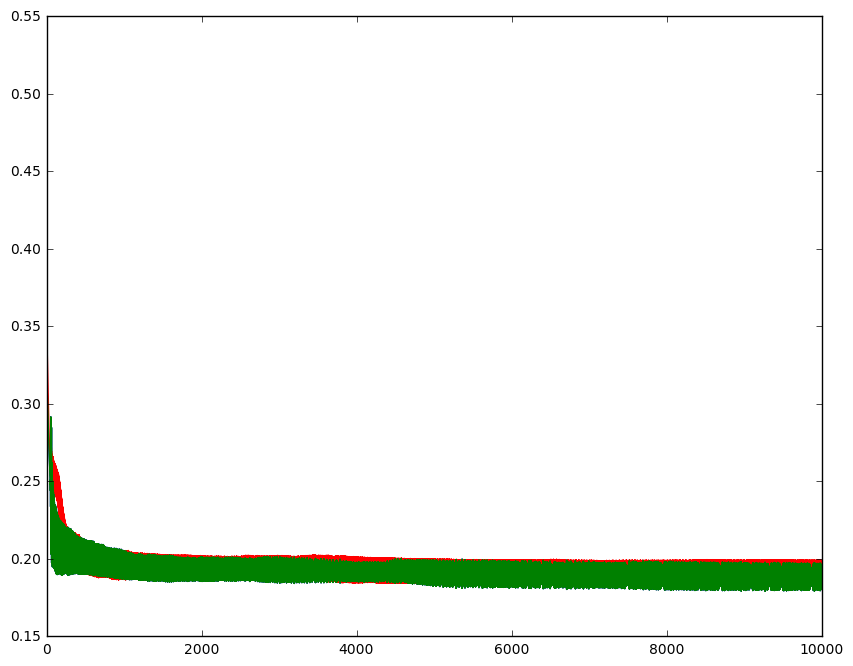

In [243]:
plt.plot(loss3, label='Default settigs')
plt.plot(loss2, c='r', label='leaky_relu')
plt.plot(loss3, c='g', label='sigmoid + dropout')
plt.show()

In [239]:
predNN = nn.predict(X_test)
predNN1 = nn1.predict(X_test)
print(accuracy(predNN, y_test),'%')
print(accuracy(predNN1, y_test),'%')
#Wierd error in 3rd NN prediction process

81.24 %
85.52 %
